In [1]:
from data.sampler import BalancedRandomBatchGeoSampler
from configs import config
from pathlib import Path
from torch.utils.data import DataLoader
from torchgeo.datasets import NAIP, stack_samples
from data.kc import KaneCounty


naip_dataset = NAIP("/net/projects/cmap/data/KC-images")

shape_path = Path(config.KC_SHAPE_ROOT) / config.KC_SHAPE_FILENAME
dataset_config = (
        config.KC_LAYER,
        config.KC_LABELS,
        config.PATCH_SIZE,
        naip_dataset.crs,
        naip_dataset.res,
    )
kc_dataset = KaneCounty(shape_path, dataset_config)
train_dataset = naip_dataset & kc_dataset

train_sampler = BalancedRandomBatchGeoSampler(
        config={
            "dataset": train_dataset,
            "size": config.PATCH_SIZE,
            "batch_size": 1,
        }
)

plot_dataloader = DataLoader(
        dataset=train_dataset,
        batch_sampler=train_sampler,
        collate_fn=stack_samples,
        num_workers=config.NUM_WORKERS,
)


In [2]:
for batch, sample in enumerate(plot_dataloader):
    print(sample['image'].shape, sample['mask'].shape)
    if batch > 2:
        break

torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])


In [10]:
def display_plot_from_tensors(sample, colors, labels, coords):
    # Call the original function with a temporary file path
    temp_path = "temp_plot.png"
    from utils.plot import plot_from_tensors
    plot_from_tensors(
        sample=sample,
        save_path=temp_path,
        colors=colors,
        labels=labels,
        coords=coords
    )
    # Now display the saved image in the notebook
    from IPython.display import Image, display
    display(Image(filename=temp_path))

Unique values in mask: tensor([0, 1])
Selected segmentation seed: 1


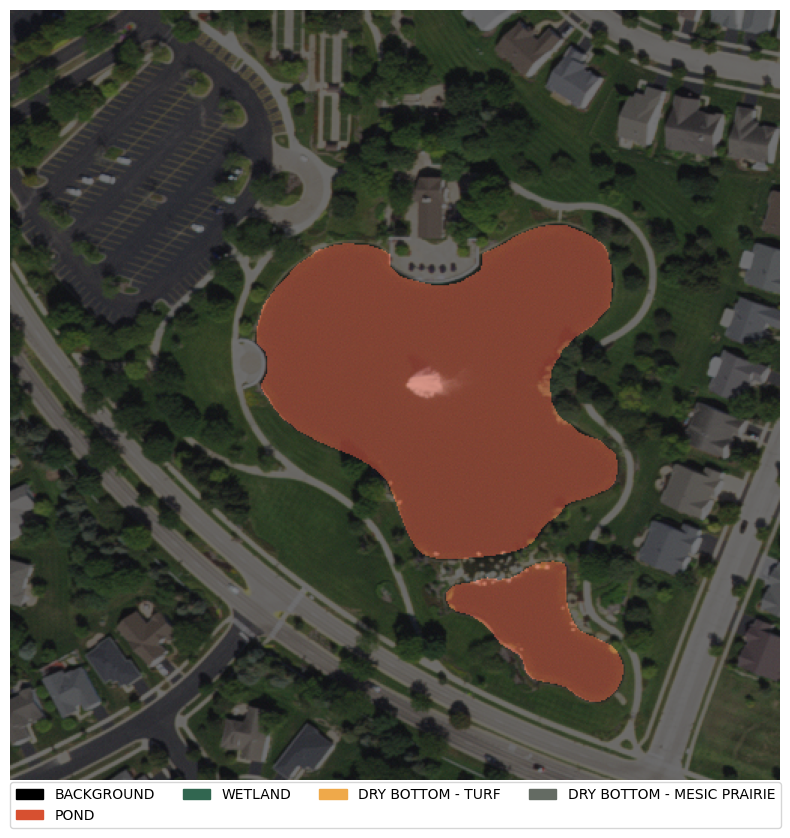

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from einops import rearrange
import torch
import numpy as np

# --- Create a custom colormap from kc_dataset.colors ---
# Sort the keys so that the colormap is consistent
sorted_keys = sorted(kc_dataset.colors.keys())
# Normalize the colors (RGB only) to [0,1]
color_list = [tuple(np.array(kc_dataset.colors[k][:3]) / 255.0) for k in sorted_keys]
custom_cmap = ListedColormap(color_list)

# --- Extract one sample from the dataloader ---
sample = next(iter(plot_dataloader))
img_tensor = sample['image'][0]  # shape: (channels, height, width)
mask_tensor = sample['mask'][0]    # shape: (height, width) or (1, height, width)

# Squeeze extra channel from mask if necessary
if mask_tensor.dim() == 3 and mask_tensor.shape[0] == 1:
    mask_tensor = mask_tensor.squeeze(0)

# Use only the first 3 channels for RGB visualization
img_rgb = img_tensor[:3] if img_tensor.shape[0] >= 3 else img_tensor

# Rearrange the image to (height, width, channels) and convert to NumPy uint8
img_rgb_np = rearrange(img_rgb, "c h w -> h w c").cpu().numpy().astype("uint8")
# Convert mask to NumPy array for plotting
mask_np = mask_tensor.cpu().numpy()

# Print unique values in mask and choose a segmentation seed (nonzero)
unique_vals = torch.unique(mask_tensor)
print("Unique values in mask:", unique_vals)
non_bg_vals = unique_vals[unique_vals != 0]  # assume 0 is background
if len(non_bg_vals) == 0:
    print("No non-background values found in this mask.")
else:
    segmentation_seed = int(non_bg_vals[0].item())
    print("Selected segmentation seed:", segmentation_seed)

# --- Create a single subplot ---
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_rgb_np)
ax.imshow(mask_np, cmap=custom_cmap, alpha=0.5, vmin=0, vmax=len(sorted_keys) - 1)
ax.axis("off")

# --- Create a legend from the colors and labels ---
legend_handles = []
for k in sorted_keys:
    label_name = kc_dataset.labels_inverse.get(k, str(k))
    # Normalize the RGB values to [0,1]
    color = tuple(np.array(kc_dataset.colors[k][:3]) / 255.0)
    patch = mpatches.Patch(color=color, label=label_name)
    legend_handles.append(patch)

fig.legend(handles=legend_handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()


In [40]:
ys, xs = torch.where(mask_tensor == segmentation_seed)
if len(xs) > 0 and len(ys) > 0:
    seed_x = xs[0].item()
    seed_y = ys[0].item()
    print(f"Segmentation seed coordinate: (x={seed_x}, y={seed_y})")
    print(f"Image dimensions: width={img_rgb_np.shape[1]}, height={img_rgb_np.shape[0]}")


Segmentation seed coordinate: (x=356, y=143)
Image dimensions: width=512, height=512


# Segmentation code:

In [25]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="/home/gregoryc25/CMAP/segment-anything/sam_vit_h.pth")
predictor = SamPredictor(sam)

Unique values in mask: tensor([0, 1])
Selected segmentation seed label: 1
Segmentation seed coordinate: (356, 143)


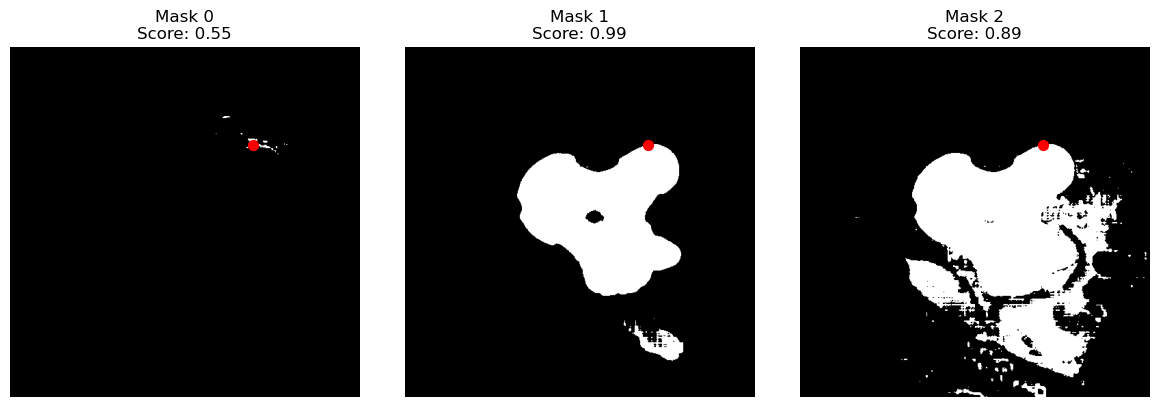

In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt

unique_vals = torch.unique(mask_tensor)
print("Unique values in mask:", unique_vals)

# Filter out background
non_bg_vals = unique_vals[unique_vals != 0]
if len(non_bg_vals) == 0:
    print("No non-background values found in the mask.")
else:
    # Select the first nonzero label as the segmentation seed label
    selected_label = int(non_bg_vals[0].item())
    print("Selected segmentation seed label:", selected_label)
    
    # Find all pixel coordinates where the mask equals the selected label
    coords = torch.where(mask_tensor == selected_label)
    if coords[0].numel() == 0:
        print("No coordinates found for label", selected_label)
    else:
        # Choose one coordinate (here, the first one)
        seed_y = coords[0][0].item()  # row index (y)
        seed_x = coords[1][0].item()  # column index (x)
        print("Segmentation seed coordinate:", (seed_x, seed_y))
        
        # Create the seed coordinate array in the expected shape (1, 2)
        seed_coordinate = np.array([[seed_x, seed_y]])
        seed_label = np.array([1])  # positive prompt
        
        # Here we assume img_rgb_np is defined (e.g., from a previous cell) as the image to segment.
        predictor.set_image(img_rgb_np)
        
        # --- Call the SAM predictor with the dynamic seed ---
        masks, scores, logits = predictor.predict(
            point_coords=seed_coordinate,
            point_labels=seed_label,
            multimask_output=True  # gives us multiple mask candidates
        )
        
        # --- Display the predicted masks in a grid with the prompt point overlaid ---
        num_masks = len(masks)
        if num_masks == 0:
            print("No masks predicted.")
        else:
            # Create a grid: one row with each mask in a separate column
            fig, axs = plt.subplots(1, num_masks, figsize=(4 * num_masks, 4))
            # Ensure axs is iterable even if there's only one mask
            if num_masks == 1:
                axs = [axs]
            for i, (mask, score) in enumerate(zip(masks, scores)):
                axs[i].imshow(mask, cmap="gray")
                # Overlay the seed coordinate (x, y) as a red circle.
                axs[i].scatter(seed_x, seed_y, color="red", s=50, marker="o")
                axs[i].set_title(f"Mask {i}\nScore: {score:.2f}")
                axs[i].axis("off")
            plt.tight_layout()
            plt.show()
